In [143]:
%matplotlib inline

import pickle
import pandas as pd
import numpy as np
import os
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from sklearn import metrics 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

dataPath = '../PedestrianData/IntentionData'
pd.__version__

'0.24.2'

#### Loading the demographic and environmental data from pickle:

In [79]:
data = pd.read_pickle('../PedestrianData/Rafael.pkl')
pd.options.display.max_columns = None
data.sample(1)

,File,Scenario,Wait Time (s),PET (s),Distace to Collision Point,Card ID,Speed Limit,Lane Width,Minimum Gap,Mean Arrival Rate,AV,Full Braking Before Impact_-1.0,Full Braking Before Impact_1,Full Braking Before Impact_2,Full Braking Before Impact_3,Snowy,One way,two way,Two way with median,Night,name,numcars,Vrexpnum,Age_9-12,Age_15-18,Age_12-15,Age_18 - 24,Age_25 - 29,Age_30 - 39,Age_40 - 49,Age_50 - 59,Age_60+,Gender_Female,Occupation_Employed,Occupation_Student,Occupation_Unemployed,Occupation_kid,Education_Bachelors degree,Education_College/University student,Education_Doctorate degree,Education_High school diploma,Education_Masters degree,Education_Professional degree,driving license_Yes,mode_Bike,mode_Car,mode_Public Transit,mode_Walking,workwalk_No,workwalk_Sometimes,workwalk_Yes,shopwalk_No,shopwalk_Sometimes,shopwalk_Yes,shopwalk_kid,Vrexp_Yes,Heart_Currently,Heart_Over the years,vision_Currently,vision_Over the years,anxiety_Currently,anxiety_Over the years,Headaches_Currently,Headaches_Over the years,dizziness_Over the years
2365,shelly/75--2018-09-7--19-50-32.txt,75,13.1696,0,1000,75,50,2.5,2,750,100,0,1,0,0,0,0,1,0,0,shelly,1,NaN,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Removing folder names from file values (some files are in subfolders)
#### Cleasing data that contain errors

In [80]:
for i in range(len(data)):
    value = data['File'].values[i].split('/')
    data['File'].values[i] = value[len(value) - 1]
    data['Wait Time (s)'] == "Err2"
    
data = data[data['Wait Time (s)'] != "Err1"]
data = data[data['Wait Time (s)'] != "Err2"]
data = data[data['Wait Time (s)'] != "Err3"]
data = data[data['Wait Time (s)'] != "Err4"]
data = data[data['Wait Time (s)'] != "Err5"]
data = data[data['Wait Time (s)'] != 0]
    
data.shape

(3410, 65)

## Curating final set of possible features

In [105]:
files = os.listdir(dataPath)

features = np.empty((len(files), 22), dtype=list)

for i in range(len(files)):
    file = dataPath + "/" + files[i]
    df = pd.read_csv(file, sep=",", header=None, 
                 names=["Time", 
                        "Pos_x", "Pos_y", "Pos_z", 
                        "Gaz_x", "Gaz_y", "Gaz_z", 
                        "Vel_x", "Vel_z",
                        "Acc_x", "Acc_z",
                        "Vel_Mag", "Acc_Mag",
                        "Vel_Ang", "Acc_Ang", "Gaz_Ang",
                        "Vel_Bin", "Acc_Bin", "Gaz_Bin", "Chg_Bin"          
                       ])
    try:
        features[i, 0] = (data.loc[data['File'] == files[i]])["Wait Time (s)"].item()
        features[i, 1] = (data.loc[data['File'] == files[i]])["Lane Width"].item()
        features[i, 2] = (data.loc[data['File'] == files[i]])["One way"].item()
        features[i, 3] = (data.loc[data['File'] == files[i]])["Snowy"].item()
        features[i, 4] = (data.loc[data['File'] == files[i]])["Night"].item()
        features[i, 5] = (data.loc[data['File'] == files[i]])["Speed Limit"].item()
        features[i, 6] = (data.loc[data['File'] == files[i]])["Mean Arrival Rate"].item()
    except:
        features[i, 0] = 0
        features[i, 1] = 0
        features[i, 2] = 0
        features[i, 3] = 0
        features[i, 4] = 0
        features[i, 5] = 0
        features[i, 6] = 0
    finally:
        # Filling the rest of the features with each direction bin
        gaze_bins = np.histogram(np.array(df["Gaz_Bin"]), bins=[1, 2, 3, 4, 5, 6, 7, 8], density=False)[0]
        change_bins = np.histogram(np.array(df["Chg_Bin"]), bins=[1, 2, 3, 4, 5, 6, 7, 8], density=False)[0]
        for j in range(len(gaze_bins)):
            features[i, j+7] = gaze_bins[j]
        for k in range(len(change_bins)):
            features[i, k+j+7] = change_bins[k]
        
# Removing data with crossing time of '0'
features = features[features[:, 0] != 0]

# Testing regression models

In [198]:
def getData(N):
    x,y =[],[]
    for i in range(N):
        c = [
            
            features[i,1], # Lane width (2, 2.5, 3)
            features[i,2], # One Way (0, 1)
            features[i,3], # Snowy (0, 1)
            features[i,4], # Night (0, 1)
            features[i,5], # Speed Limit (30, 40, 50)
            features[i,6], # Mean Arrival
            # head pose bins
            features[i,7], features[i,8], features[i,9], features[i,10], features[i,11], features[i,12], features[i,13], 
            # change pose bins
            #features[i,14], features[i,15], features[i,16], features[i,17], features[i,18], features[i,19]
            
        ]
        yy = features[i, 0]
        x.append(c)
        y.append(yy)
    return np.array(x), np.array(y)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

def evaluate_mse(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = np.sqrt(mean_squared_error(y_test, predictions))
    print('Model Performance')
    print('MSE of: ', errors)
    
    return errors
    
X,y=getData(len(features))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2, random_state=42)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

In [ ]:
print(rf_random.best_params_)
print(grid_search.best_params_)

In [223]:
base_model = RandomForestRegressor(random_state = 42, bootstrap = True, n_estimators = 100)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
base_mse = evaluate_mse(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
random_mse = evaluate_mse(best_random, X_test, y_test)

print('\n')
print('Accuracy Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
print('MSE Improvement of {:0.2f}%.'.format(-100 * (random_mse - base_mse) / base_mse))

Model Performance
Average Error: 2.6914 degrees.
Accuracy = 82.39%.
Model Performance
MSE of:  4.705418014505513
Model Performance
Average Error: 2.6396 degrees.
Accuracy = 82.58%.
Model Performance
MSE of:  4.439720794344002


Accuracy Improvement of 0.22%.
MSE Improvement of 5.65%.


In [188]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.7min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

R^2: 0.7869977556714775
Mean Absolute Error: 2.691396208741497
Mean Squared Error: 22.140958691233006
Root Mean Squared Error: 4.705418014505513
Scores: [0.68673216 0.71451451 0.76585486 0.83873951 0.7850545  0.81271927
 0.7956149  0.79796805 0.75364579 0.88939804]
Mean: 0.7840241574017811
Standard deviation: 0.055498617537553065


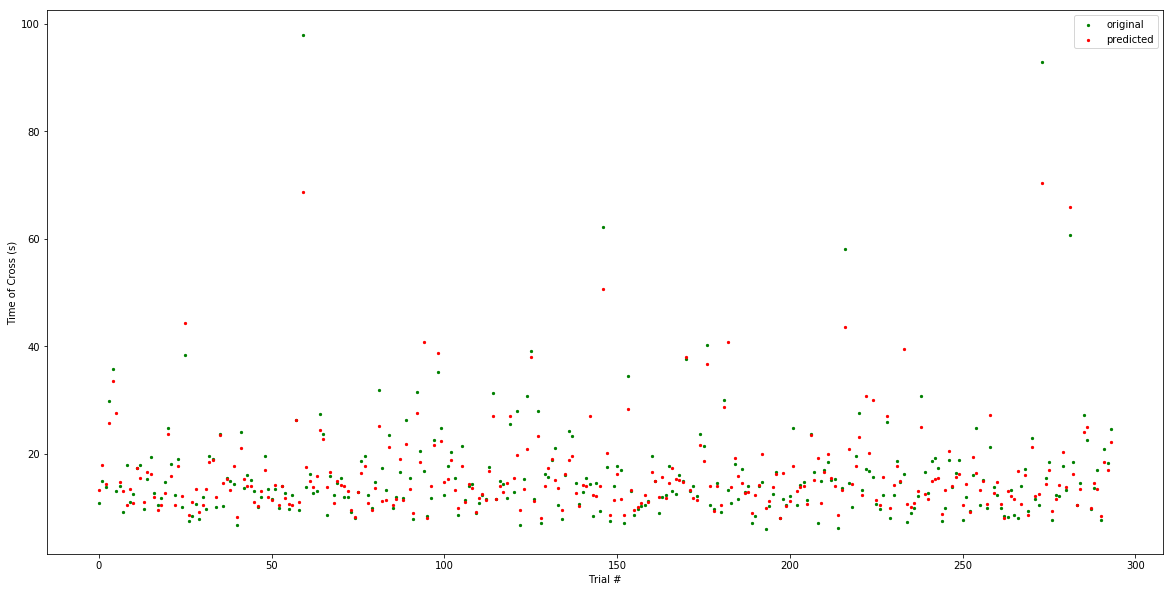

In [225]:
forest_reg = RandomForestRegressor(random_state = 42, bootstrap = True, n_estimators = 100)  
forest_reg.fit(X_train, y_train)

y_pred = forest_reg.predict(X_test)  

print('R^2:', metrics.r2_score(y_test,y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

scores = cross_val_score(forest_reg, X, y, cv=10)
display_scores(scores)

x_ax=range(len(y_pred))
plt.figure(figsize=(20, 10)) 
plt.scatter(x_ax, y_test, s=5, color="green", label="original")
plt.scatter(x_ax, y_pred, s=5, color="red", label="predicted")
    
plt.xlabel("Trial #")
plt.ylabel("Time of Cross (s)")
plt.legend()
plt.show()